In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1120d6fd091abbb93d73043e8a37ca65d1d3b52623e15b702acdb5abc5fbf586
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("EDA") \
    .getOrCreate()

In [4]:
# Load the dataset into a PySpark DataFrame
df = spark.read.csv("/content/drive/MyDrive/ProjectTweets.csv", header=True, inferSchema=True)


In [7]:
# Inspect the data
df.printSchema()


root
 |-- 0: integer (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)



In [8]:
df.show()

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [11]:
# Rename columns to meaningful names
from pyspark.sql.functions import col
# Rename columns to meaningful names
tweets_df = df.select(
    col("1467810369").alias("tweet_id"),
    col("Mon Apr 06 22:19:45 PDT 2009").alias("timestamp"),
    col("NO_QUERY").alias("query"),
    col("_TheSpecialOne_").alias("username"),
    col("`@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D`").alias("text")
)

# Display the schema and first few rows of the DataFrame
tweets_df.printSchema()


root
 |-- tweet_id: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)



In [13]:
tweets_df.show(20, truncate=False)

+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|tweet_id  |timestamp                   |query   |username       |text                                                                                                                 |
+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |
|1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus       |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                            |
|1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|ElleCTF        |my whole 

In [16]:
from pyspark.sql.functions import col, sum

# Create expressions to count null values as 1 and non-null values as 0
exprs = [sum(col(c).isNull().cast('int')).alias(c) for c in tweets_df.columns]

# Apply the expressions to the DataFrame and aggregate the results
null_counts = tweets_df.agg(*exprs)

# Display null counts
null_counts.show()


+--------+---------+-----+--------+----+
|tweet_id|timestamp|query|username|text|
+--------+---------+-----+--------+----+
|       0|        0|    0|       0|   0|
+--------+---------+-----+--------+----+



In [25]:
# Summary statistics
summary = tweets_df.describe().toPandas()



In [24]:
summary.head()

,summary,tweet_id,timestamp,query,username,text
0,count,1599999,1599999,1599999,1599999,1599999
1,mean,1.9988178841753244E9,None,None,4.325887521835714E9,None
2,stddev,1.9357567891730213E8,None,None,5.16273321845489E10,None
3,min,1467810672,Fri Apr 17 20:30:31 PDT 2009,NO_QUERY,000catnap000,exh...
4,max,2329205794,Wed May 27 07:27:38 PDT 2009,NO_QUERY,zzzzeus111,ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½Ç¿ï¿½ï¿½ï¿½ï¿½ï¿½Ð¶ï¿½Øï¿...


In [38]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from textblob import TextBlob
import re

In [39]:
# Define a user-defined function (UDF) for text cleaning
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters, punctuation, and links using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

In [40]:
# Register the UDF
clean_text_udf = udf(clean_text, StringType())

In [41]:
# Apply the UDF to the 'text' column to clean the text data
tweets_df = tweets_df.withColumn("clean_text", clean_text_udf(col("text")))


In [42]:
# Filter out tweets with empty or null cleaned text
tweets_df = tweets_df.filter(col("clean_text").isNotNull() & (col("clean_text") != ""))


In [43]:
# Define a user-defined function (UDF) to perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    # Perform sentiment analysis using TextBlob
    analysis = TextBlob(text)
    # Return the sentiment polarity as a string
    return "positive" if analysis.sentiment.polarity > 0 else "negative" if analysis.sentiment.polarity < 0 else "neutral"


In [44]:
# Register the UDF
sentiment_udf = udf(analyze_sentiment, StringType())

In [45]:
# Apply the UDF to the 'clean_text' column to add a new column 'sentiment'
tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(col("clean_text")))


In [46]:
tweets_df.show(5)

+----------+--------------------+--------+-------------+--------------------+--------------------+---------+
|  tweet_id|           timestamp|   query|     username|                text|          clean_text|sentiment|
+----------+--------------------+--------+-------------+--------------------+--------------------+---------+
|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|is upset that he ...|  neutral|
|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|kenichan i dived ...| positive|
|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|my whole body fee...| positive|
|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|nationwideclass n...| negative|
|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|kwesidei not the ...| positive|
+----------+--------------------+--------+-------------+--------------------+--------------------+---------+
only showing top 5 

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


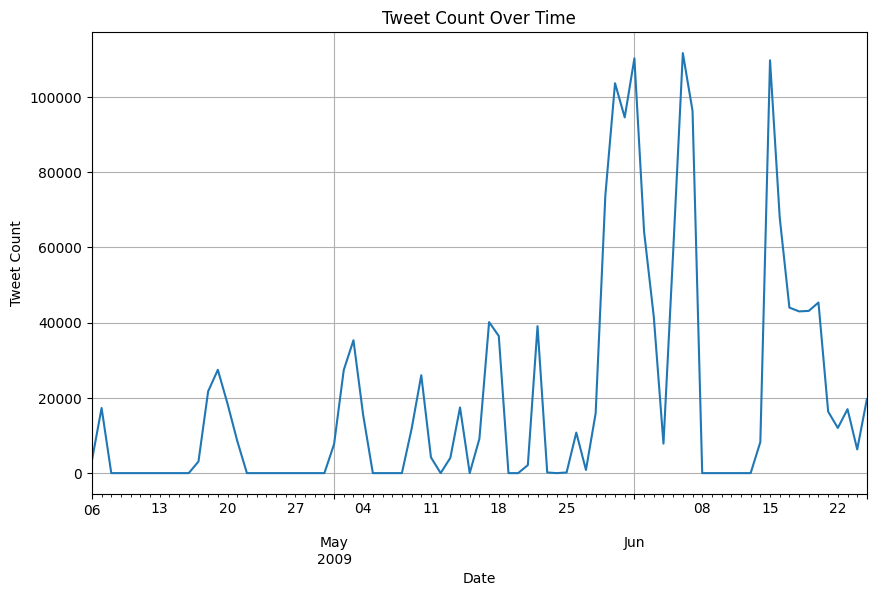

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame for visualization
tweets_pd = tweets_df.select("timestamp").toPandas()

# Convert timestamp column to datetime
tweets_pd['timestamp'] = pd.to_datetime(tweets_pd['timestamp'])

# Extract date and count occurrences
tweets_count_by_date = tweets_pd.resample('D', on='timestamp').size()

# Plot tweet count over time
plt.figure(figsize=(10, 6))
tweets_count_by_date.plot()
plt.title('Tweet Count Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.grid(True)
plt.show()


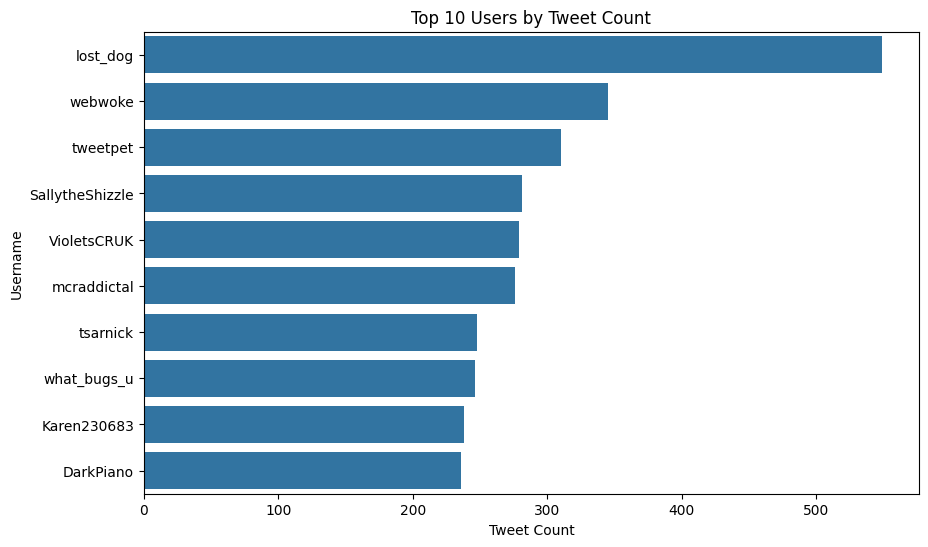

In [48]:
from wordcloud import WordCloud
import seaborn as sns

# Distribution of Tweets by Username
username_counts = tweets_df.groupBy("username").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="username", data=username_counts)
plt.title('Top 10 Users by Tweet Count')
plt.xlabel('Tweet Count')
plt.ylabel('Username')
plt.show()

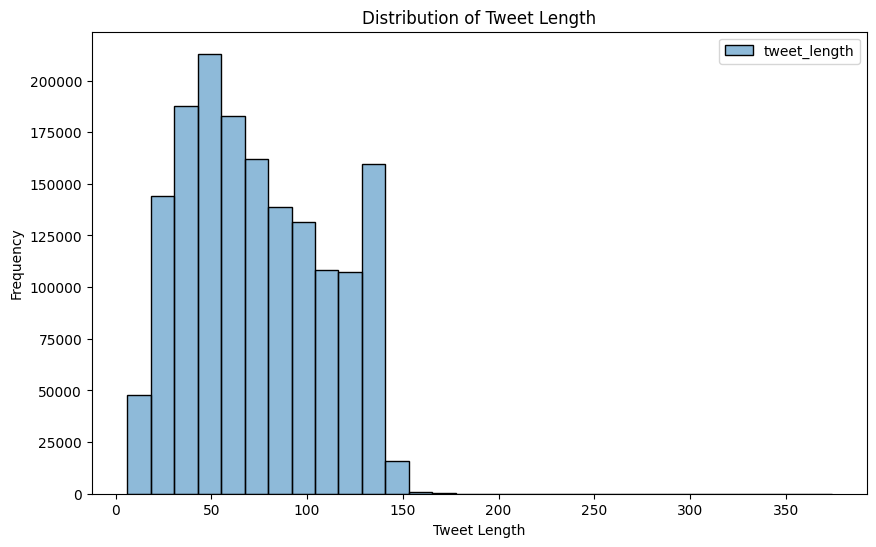

In [49]:
# Distribution of Tweet Length
tweet_length = tweets_df.selectExpr("length(text) as tweet_length").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(tweet_length, bins=30)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


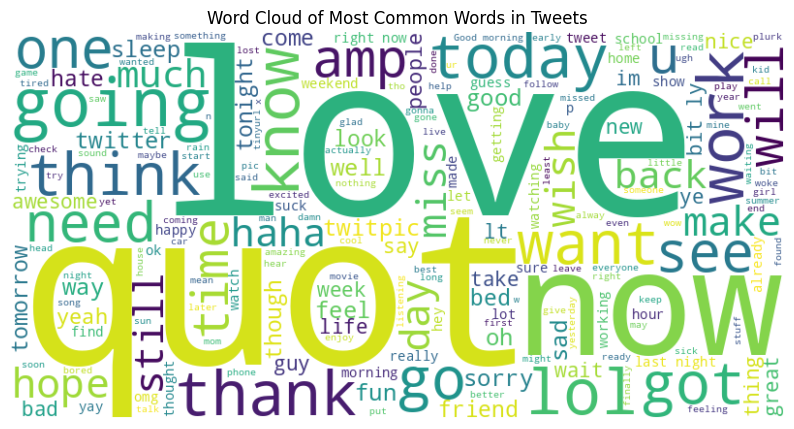

In [50]:
# Word Cloud of Most Common Words in Tweets
text = ' '.join(tweets_df.select("text").rdd.flatMap(lambda x: x).collect())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Most Common Words in Tweets')
plt.axis('off')
plt.show()